## Libraries

In [1]:
import os
import re
import json
import pandas as pd
import pickle
import networkx as nx
from collections import defaultdict
import community as community_louvain
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

In [2]:
import pandas as pd

# Load the filtered dataset
file_path = 'filtered_reviews_open2018_2019.csv'
data = pd.read_csv(file_path)

# Load the graph (replace with your graph file or generation method)
with open('business_graph_threshold.pkl', 'rb') as f:
    G = pickle.load(f)

# Get the list of nodes (business IDs) in the network G
network_business_ids = set(G.nodes)

# Filter the dataset to include only business IDs in the network
filtered_data_in_network = data[data['business_id'].isin(network_business_ids)]

# Save the new filtered dataset to a CSV file
output_file_path = 'filtered_reviews_in_network.csv'
filtered_data_in_network.to_csv(output_file_path, index=False)

print(f"Filtered dataset saved to: {output_file_path}")
print(f"Number of rows in the new dataset: {filtered_data_in_network.shape[0]}")


Filtered dataset saved to: filtered_reviews_in_network.csv
Number of rows in the new dataset: 819756


## Adding attributes to the nodes 

In [3]:
# Load the dataset
data = pd.read_csv('filtered_reviews_in_network.csv')

# Normalize categories to lists of strings and exclude 'Food' and 'Restaurants'
def normalize_categories(categories):
    excluded_categories = {'Food', 'Restaurants'}
    if isinstance(categories, str):
        return [
            cat.strip() 
            for cat in categories.split(",") 
            if cat.strip() not in excluded_categories
        ]
    return ["No Category"]  # Default for missing or malformed categories

# Apply normalization to the 'categories' column in the dataset
data['categories'] = data['categories'].apply(normalize_categories)

# Create a mapping from business_id to categories and city
categories_mapping = data.set_index('business_id')['categories'].to_dict()
city_mapping = data.set_index('business_id')['city'].to_dict()

# Load the graph (replace with your graph file or generation method)
with open('business_graph_threshold.pkl', 'rb') as f:
    G = pickle.load(f)

# Add 'categories' as a node attribute
nx.set_node_attributes(G, categories_mapping, 'categories')

# Add 'city' as a node attribute
nx.set_node_attributes(G, city_mapping, 'city')

# Save the updated graph
with open('business_graph_with_attributes.pkl', 'wb') as f:
    pickle.dump(G, f)

print("Node attributes 'categories' and 'city' added successfully!")


Node attributes 'categories' and 'city' added successfully!


In [4]:
# Get the number of nodes (restaurants) and edges (connections between restaurants)
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the results
print(f"Number of restaurants (nodes): {num_nodes}")
print(f"Number of connections (edges): {num_edges}")

Number of restaurants (nodes): 8512
Number of connections (edges): 32471


### Checking to see if attributes are added correctly

In [11]:
# Check the attributes of a sample business node
sample_node = list(G.nodes)[28]
print(f"Node: {sample_node}")
print(f"Attributes: {G.nodes[sample_node]}")

Node: VPqWLp9kMiZEbctCebIZUA
Attributes: {'categories': ['Bars', 'Moroccan', 'Wine Bars', 'Breakfast & Brunch', 'Nightlife', 'Middle Eastern'], 'city': 'Vancouver'}


In [12]:
G_undirected = G.to_undirected()

In [13]:
# Get the number of nodes (restaurants) and edges (connections between restaurants)
num_nodes = G_undirected.number_of_nodes()
num_edges = G_undirected.number_of_edges()

# Print the results
print(f"Number of restaurants (nodes): {num_nodes}")
print(f"Number of connections (edges): {num_edges}")

Number of restaurants (nodes): 8512
Number of connections (edges): 32471


In [14]:
import pandas as pd

# Load the CSV file
file_path = 'filtered_reviews_in_network.csv'
data = pd.read_csv(file_path)

# Count unique business IDs
unique_business_ids = data['business_id'].nunique()

print(f"Number of unique business IDs: {unique_business_ids}")


Number of unique business IDs: 8512


## Calculating the modularity 

In [24]:
from collections import Counter, defaultdict

def calculate_category_weights(graph):
    # Step 1: Map each node to its categories
    node_categories = defaultdict(set)

    for node in graph.nodes:
        # Retrieve categories from node attributes
        raw_categories = graph.nodes[node].get('categories', [])
        
        # Ensure categories are in a proper format
        if isinstance(raw_categories, list):
            categories = raw_categories
        elif isinstance(raw_categories, str):
            categories = raw_categories.split(", ")
        else:
            categories = []
        
        # Map node (business) to its categories
        node_categories[node].update(categories)

    # Debug: Print node to category mapping
    print(f"Node to Categories Mapping: {dict(node_categories)}")

    # Step 2: Count category occurrences across nodes
    category_weights = Counter()
    for categories in node_categories.values():
        for category in categories:
            category_weights[category] += 1

    # Debug: Print category weights
    print(f"Category Weights: {category_weights}")

    return dict(category_weights)

# Example Usage:
# Assuming G_undirected is your graph
category_weights = calculate_category_weights(G_undirected)
print("Final Category Weights:", category_weights)


Node to Categories Mapping: {'rgGJMwcrNTuCcY493q_YuA': {'Cocktail Bars', 'Barbeque', 'Nightlife', 'American (New)', 'Bars'}, 'YZs1gNSh_sN8JmN_nrpxeA': {'Sandwiches', 'Southern', 'Salad', 'Barbeque'}, '5OAi35OianJzCnIsL8aOFQ': {'Food Trucks', 'Mexican'}, 'bZiIIUcpgxh8mpKMDhdqbA': {'American (Traditional)', 'American (New)', 'Burgers'}, 'F6b_O4-wtd3956YOvAoerg': {'American (New)', 'Nightlife', 'Bars'}, '_QUh5vFHSuw8R_uiFZ7XKQ': {'Sandwiches', 'Cocktail Bars', 'American (Traditional)', 'Desserts', 'Nightlife', 'American (New)', 'Cafes', 'Bars'}, 'KEh3efWSOIzd8BvuW-X4-g': {'American (Traditional)', 'Diners', 'Breakfast & Brunch'}, 'v1UzkU8lEWdjxq8byWFOKg': {'Chicken Shop', 'Chicken Wings', 'Comfort Food', 'Southern', 'Soul Food'}, '9UThLJTuOQPLcDCLx5BVqw': {'Japanese', 'Sushi Bars'}, '2WRCcQATOe_Em0k61T6kvQ': {'Korean', 'Barbeque'}, 'tliWLQ3EfaOqlwyYu0gAmA': {'Cafes', 'Breakfast & Brunch', 'Coffee & Tea'}, 'oug5bLTWP_YTtj1C3_X6Xw': {'American (Traditional)', 'Karaoke', 'Comfort Food', 'Nig

In [26]:
from collections import defaultdict, Counter
import random
import numpy as np
from community import community_louvain  # Requires `python-louvain`

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)


# Function to calculate modularity
def calculate_modularity(graph, communities):
    L = graph.number_of_edges()
    modularity = 0
    for community in communities:
        subgraph = graph.subgraph(community)
        L_c = subgraph.number_of_edges()
        k_c = sum(dict(graph.degree(community)).values())
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    return modularity


# Function to calculate category weights
def calculate_category_weights(graph):
    business_categories = defaultdict(set)
    
    for node in graph.nodes:
        raw_categories = graph.nodes[node].get('categories', [])
        
        # Normalize categories
        if isinstance(raw_categories, list):
            categories = raw_categories
        elif isinstance(raw_categories, str):
            categories = raw_categories.split(", ")
        else:
            categories = []
        
        business_categories[node].update(categories)

    category_weights = Counter()
    for categories in business_categories.values():
        for category in categories:
            category_weights[category] += 1

    return dict(category_weights)


# Step 1: Community detection using Louvain
louvain_partition = community_louvain.best_partition(G_undirected)
louvain_communities = defaultdict(list)
for node, community_id in louvain_partition.items():
    louvain_communities[community_id].append(node)

louvain_community_list = list(louvain_communities.values())

# Calculate modularity for Louvain communities
louvain_modularity_manual = calculate_modularity(G_undirected, louvain_community_list)
print(f"Louvain Modularity (Manual): {louvain_modularity_manual:.4f}")


# Step 2: Category-based communities
category_communities = defaultdict(list)
for node in G_undirected.nodes:
    categories = G_undirected.nodes[node].get('categories', ["No Category"])
    for category in categories:
        category_communities[category].append(node)

category_community_list = list(category_communities.values())
category_modularity_manual = calculate_modularity(G_undirected, category_community_list)
print(f"Category-based Modularity (Manual): {category_modularity_manual:.4f}")


# Step 3: Filtered category-based communities
excluded_categories = {'Restaurants', 'Food'}
category_communities_filtered = defaultdict(list)
for node in G_undirected.nodes:
    categories = G_undirected.nodes[node].get('categories', ["No Category"])
    for category in categories:
        if category not in excluded_categories:
            category_communities_filtered[category].append(node)

filtered_category_community_list = list(category_communities_filtered.values())
filtered_category_modularity_manual = calculate_modularity(G_undirected, filtered_category_community_list)
print(f"Category-based Modularity (Filtered): {filtered_category_modularity_manual:.4f}")


# Step 4: City-based communities
city_communities = defaultdict(list)
for node in G_undirected.nodes:
    city = G_undirected.nodes[node].get('city', 'No Category')
    city_communities[city].append(node)

city_community_list = list(city_communities.values())
city_modularity_manual = calculate_modularity(G_undirected, city_community_list)
print(f"City-based Modularity (Manual): {city_modularity_manual:.4f}")


# Step 5: Communities based on highest-weighted category
# Calculate category weights
category_weights = calculate_category_weights(G_undirected)
print("Final Category Weights:", category_weights)

# Assign highest-weighted category to each node
highest_weighted_category = {}
for node in G_undirected.nodes:
    categories = G_undirected.nodes[node].get('categories', ["No Category"])
    if categories:
        highest_weighted_category[node] = max(categories, key=lambda c: category_weights.get(c, 0))
    else:
        highest_weighted_category[node] = "No Category"

# Group nodes by highest-weighted category
weighted_category_communities = defaultdict(list)
for node, category in highest_weighted_category.items():
    weighted_category_communities[category].append(node)

# Convert to list of lists
weighted_category_community_list = list(weighted_category_communities.values())

# Calculate modularity for highest-weighted category communities
weighted_category_modularity_manual = calculate_modularity(G_undirected, weighted_category_community_list)
print(f"Highest-Weighted Category-based Modularity (Manual): {weighted_category_modularity_manual:.4f}")


Louvain Modularity (Manual): 0.9481
Category-based Modularity (Manual): 0.7838
Category-based Modularity (Filtered): 0.7838
City-based Modularity (Manual): 0.4988
Final Category Weights: {'Cocktail Bars': 630, 'Barbeque': 317, 'Nightlife': 2335, 'American (New)': 1282, 'Bars': 2274, 'Sandwiches': 1004, 'Southern': 211, 'Salad': 590, 'Food Trucks': 200, 'Mexican': 688, 'American (Traditional)': 1388, 'Burgers': 645, 'Desserts': 519, 'Cafes': 571, 'Diners': 242, 'Breakfast & Brunch': 1252, 'Chicken Shop': 81, 'Chicken Wings': 244, 'Comfort Food': 184, 'Soul Food': 51, 'Japanese': 727, 'Sushi Bars': 561, 'Korean': 237, 'Coffee & Tea': 730, 'Karaoke': 20, 'Pubs': 296, 'Gastropubs': 172, 'Singaporean': 14, 'Malaysian': 31, 'Wine Bars': 353, 'Italian': 649, 'Seafood': 898, 'Dim Sum': 110, 'Chinese': 665, 'Vegetarian': 387, 'Gluten-Free': 286, 'Vegan': 311, 'Internet Cafes': 17, 'Noodles': 284, 'Soup': 261, 'Ramen': 159, 'Tapas Bars': 116, 'Beer Bar': 190, 'French': 129, 'Asian Fusion': 523, 

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)


# Community detection based on Louvain algorithm
louvain_partition = community_louvain.best_partition(G_undirected)
louvain_communities = defaultdict(list)
for node, community_id in louvain_partition.items():
    louvain_communities[community_id].append(node)

louvain_community_list = list(louvain_communities.values())

# Manual calculation of modularity for Louvain communities
def calculate_modularity(graph, communities):
    L = graph.number_of_edges()
    modularity = 0
    for community in communities:
        subgraph = graph.subgraph(community)
        L_c = subgraph.number_of_edges()
        k_c = sum(dict(graph.degree(community)).values())
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    return modularity

# Calculate modularity for Louvain communities
louvain_modularity_manual = calculate_modularity(G_undirected, louvain_community_list)

# Print modularity results
print(f"Louvain Modularity (Manual): {louvain_modularity_manual:.4f}")


# Group nodes by individual categories
category_communities = defaultdict(list)
for node in G_undirected.nodes:
    # Retrieve the list of categories for the node
    categories = G_undirected.nodes[node].get('categories', ["No Category"])
    # Ensure categories is a list and group nodes by each category
    for category in categories:
        category_communities[category].append(node)
        
# Convert the communities into a list of lists
category_community_list = list(category_communities.values())
# Calculate modularity for category-based communities
category_modularity_manual = calculate_modularity(G_undirected, category_community_list)

print(f"Category-based Modularity (Manual): {category_modularity_manual:.4f}")

# Group nodes by individual categories, excluding 'Restaurant' and 'Food'
excluded_categories = {'Restaurants', 'Food'}

category_communities_filtered = defaultdict(list)
for node in G_undirected.nodes:
    # Retrieve the list of categories for the node
    categories = G_undirected.nodes[node].get('categories', ["No Category"])
    # Ensure categories is a list and exclude unwanted categories
    for category in categories:
        if category not in excluded_categories:
            category_communities_filtered[category].append(node)

# Convert the filtered communities into a list of lists
filtered_category_community_list = list(category_communities_filtered.values())

# Calculate modularity for filtered category-based communities
filtered_category_modularity_manual = calculate_modularity(G_undirected, filtered_category_community_list)

print(f"Category-based Modularity (Filtered): {filtered_category_modularity_manual:.4f}")

# Group nodes by cities 
city_communities = defaultdict(list)
for node in G_undirected.nodes:
    city = G_undirected.nodes[node].get('city', 'No Category')
    city_communities[city].append(node)

city_community_list = list(city_communities.values())
city_modularity_manual = calculate_modularity(G_undirected, city_community_list)

print(f"City-based Modularity (Manual): {city_modularity_manual:.4f}")

Louvain Modularity (Manual): 0.9481
Category-based Modularity (Manual): 0.7838
Category-based Modularity (Filtered): 0.7838
City-based Modularity (Manual): 0.4988


In [71]:
import pandas as pd

# Load the filtered data
filtered_data_path = 'filtered_reviews_in_network.csv'
filtered_data = pd.read_csv(filtered_data_path)

# Ensure 'business_id' is consistent with the Louvain partition
filtered_data['business_id'] = filtered_data['business_id'].astype(str)

# Map Louvain community numbers to the businesses
business_to_community = {node: community_id for node, community_id in louvain_partition.items()}

# Add a new column for the Louvain community number
filtered_data['louvain_community'] = filtered_data['business_id'].map(business_to_community)

# Save the updated file
output_file_path = 'filtered_reviews_with_communities.csv'
filtered_data.to_csv(output_file_path, index=False)

print(f"Updated file with Louvain community numbers saved as: {output_file_path}")

Updated file with Louvain community numbers saved as: filtered_reviews_with_communities.csv


## D-Matrix louvain vs. city and louvain vs. category 

### Louvain vs. categories

Top 7 Categories by Frequency: ['Nightlife', 'American (Traditional)', 'Japanese', 'Breakfast & Brunch', 'Sandwiches', 'Chinese', 'American (New)']


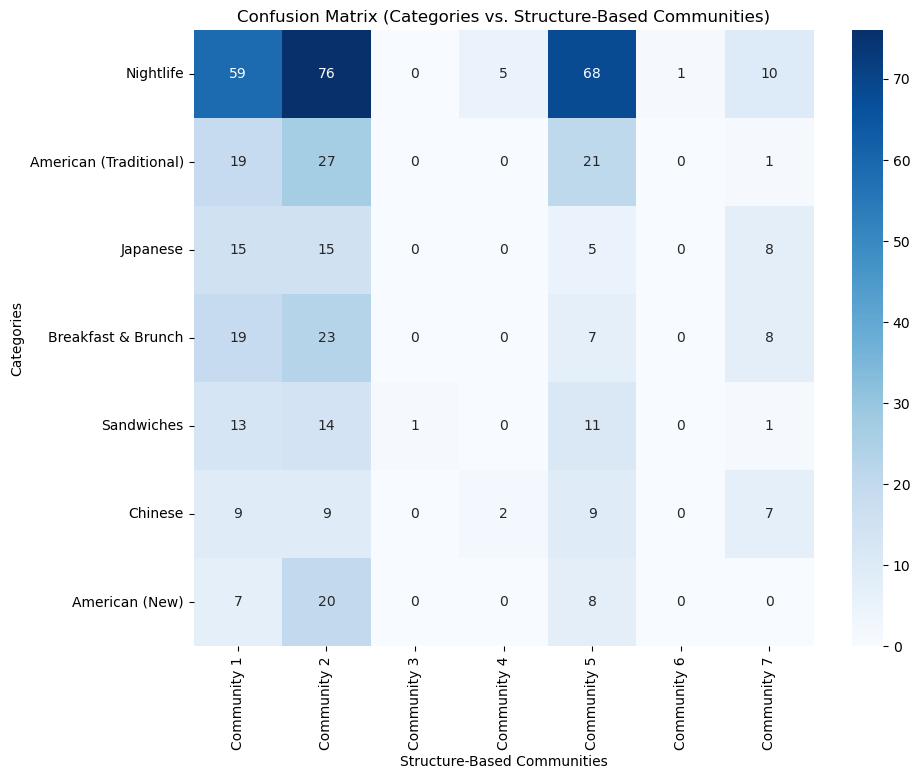

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Step 1: Calculate category weights and assign the highest-weighted category
category_weights = calculate_category_weights(G_undirected)

# Assign each node its highest-weighted category
for node in G_undirected.nodes:
    # Retrieve categories
    all_categories = G_undirected.nodes[node].get('categories', ["No Category"])
    if isinstance(all_categories, str):
        all_categories = [cat.strip() for cat in all_categories.split(",")]
    
    # Assign the single highest-weighted category
    if all_categories:
        highest_category = max(all_categories, key=lambda cat: category_weights.get(cat, 0))
    else:
        highest_category = "No Category"
    
    G_undirected.nodes[node]['categories'] = highest_category

# Step 2: Identify top 7 categories by frequency
# Extract the single assigned categories
all_categories_list = list(nx.get_node_attributes(G_undirected, 'categories').values())
category_frequency = Counter(all_categories_list)

# Get the top 7 categories by frequency
top_categories = [category for category, _ in category_frequency.most_common(7)]
print(f"Top 7 Categories by Frequency: {top_categories}")

# Step 3: Identify top 7 structure-based communities by size
top_communities = sorted(louvain_community_list, key=len, reverse=True)[:7]

# Create a community label mapping for each node from Louvain partition
community_labels = {node: community_id for community_id, nodes in enumerate(louvain_community_list) for node in nodes}

# Initialize the matrix D (7x7) for top categories and communities
D = [[0 for _ in range(len(top_communities))] for _ in range(len(top_categories))]

# Create index mappings for the top categories and communities
category_index = {category: idx for idx, category in enumerate(top_categories)}
community_index = {community_id: idx for idx, community_id in enumerate(range(len(top_communities)))}

# Step 4: Populate the matrix D
for node in G_undirected.nodes:
    # Retrieve the single highest-weighted category
    category = G_undirected.nodes[node]['categories']
    node_community = community_labels[node]  # Get the community label from Louvain
    
    # Check if the node's community is in the top 7 communities
    if node_community in community_index:
        community_idx = community_index[node_community]
        
        # Update D for the node's category if it's in the top 7 categories
        if category in category_index:
            category_idx = category_index[category]
            D[category_idx][community_idx] += 1

# Step 5: Visualize the matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    D, annot=True, fmt="d", cmap="Blues",
    xticklabels=[f"Community {i+1}" for i in range(7)],
    yticklabels=top_categories
)
plt.xlabel("Structure-Based Communities")
plt.ylabel("Categories")
plt.title("Confusion Matrix (Categories vs. Structure-Based Communities)")
plt.show()


### Louvain vs. City

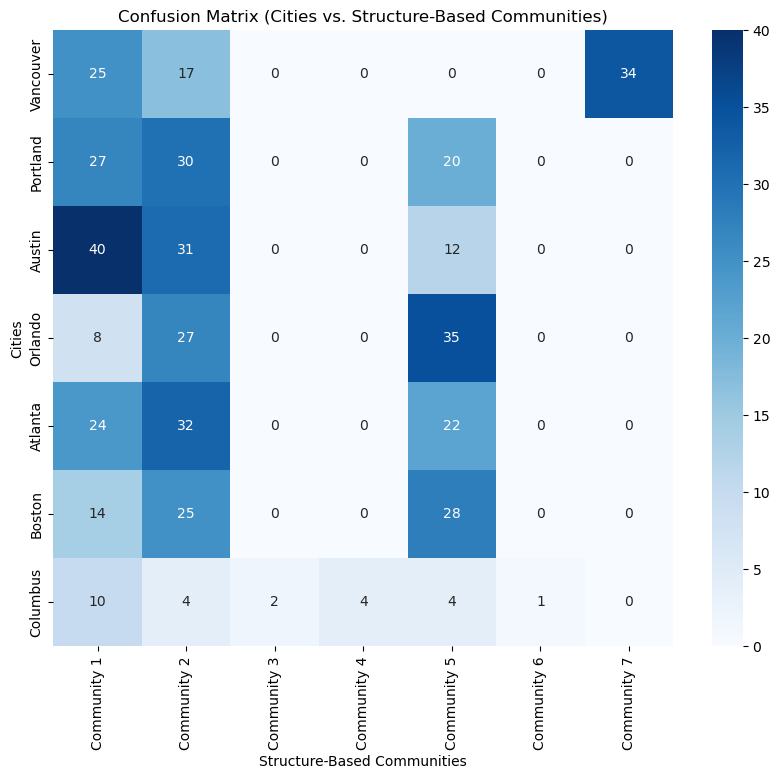

In [56]:
# Ensure cities are properly assigned as a node attribute in G_undirected
for node in G_undirected.nodes:
    city = G_undirected.nodes[node].get('city', "No City")  # Default to "No City"
    G_undirected.nodes[node]['city'] = city

# Identify the top 7 cities by frequency across all businesses
all_cities_list = list(nx.get_node_attributes(G_undirected, 'city').values())
top_cities = [city for city, _ in Counter(all_cities_list).most_common(7)]

# Step 3: Identify top 7 structure-based communities by size
top_communities_forC = sorted(louvain_community_list, key=len, reverse=True)[:7]

# Initialize the matrix D_City (7x7) for top cities and communities
D_City = [[0 for _ in range(len(top_communities_forC))] for _ in range(len(top_cities))]

# Create index mappings for the top cities
city_index = {city: idx for idx, city in enumerate(top_cities)}

# Fill the matrix D_City by counting overlaps
for node in G_undirected.nodes:
    city = G_undirected.nodes[node]['city']  # Access the city attribute
    node_community = community_labels[node]  # Get the community label from Louvain

    # Check if the node's community is in the top 7 communities and its city is in the top 7 cities
    if node_community in community_index and city in city_index:
        city_idx = city_index[city]
        community_idx = community_index[node_community]
        D_City[city_idx][community_idx] += 1

# Visualize the matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    D_City, annot=True, fmt="d", cmap="Blues",
    xticklabels=[f"Community {i+1}" for i in range(7)],
    yticklabels=top_cities
)
plt.xlabel("Structure-Based Communities")
plt.ylabel("Cities")
plt.title("Confusion Matrix (Cities vs. Structure-Based Communities)")
plt.show()


## TF-IDF Analysis 

### Dictionary of all reviews for each restaurant 

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenate all reviews for each restaurant
restaurant_reviews = data.groupby('business_id')['text_'].apply(' '.join).to_dict()

# Check a sample
print(f"Sample restaurant reviews: {list(restaurant_reviews.items())[:5]}")


Sample restaurant reviews: [('--UNNdnHRhsyFUbDgumdtQ', 'We felt so attended to with our meal. Two of our party of four had a food sensitivity, and after we were seated the chef came over, sat down with us, and worked out two entrees we would be able to eat. He prepared two off-menu plates for us, creative food art. So many flavors and textures! Our dinner conversation kept halting because one or another of our party would take another bite and disappear into a revery until done tasting. The portions were perfectly sized to be satisfying without overindulgence. Which left us able to enjoy desserts, which continued the pattern of each dish being a multiplicity of flavors working together for surprise and delight. All in all, one of the most pleasant dining experiences of my life. As James Osland would say... 5 stars. We love this place! 7 year anniversary spent here enjoying the food, wine pairing and non-alcoholic drink pairing. Great service and amazing creations with tons of ingredien

In [32]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')  # Adjust max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(restaurant_reviews.values())

# Output: TF-IDF sparse matrix
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")  # (n_restaurants, n_features)

TF-IDF Matrix Shape: (8512, 500)


In [33]:
# Check if all nodes in louvain_partition are present in data['business_id']
nodes_in_data = set(data['business_id'])
unmatched_nodes = [node for node in louvain_partition.keys() if node not in nodes_in_data]

print(f"Number of unmatched nodes: {len(unmatched_nodes)}")
if unmatched_nodes:
    print(f"Sample unmatched nodes: {unmatched_nodes[:10]}")


Number of unmatched nodes: 0


In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Group Reviews by Louvain Communities
# `louvain_partition` maps each restaurant (node) to a community ID
community_reviews = defaultdict(str)

# Assuming `data` contains `business_id` and `text_`
for node, community_id in louvain_partition.items():
    if node in data['business_id'].values:
        # Concatenate reviews for each business in the same community
        reviews = data.loc[data['business_id'] == node, 'text_'].dropna().tolist()
        community_reviews[community_id] += " ".join(reviews)

# Print the first few communities and their aggregated reviews
for community_id, reviews in list(community_reviews.items())[:5]:
    print(f"Community {community_id}: {reviews[:200]}")  # Print the first 200 characters of reviews

Community 0: This is a great find here in the Couve. Service is as good as the food and the food is wonderful. The offerings on the menu look fairly standard at first but as you browse for a tasty delight you will
Community 1: So damn good! Go with a big appetite! Huevos Rancheros are one of the best items on the menu. Cool vibes. Order and sit down place. Crazy menu. Fire food. Desserts are looking bomb.  Try if your in th
Community 2: This is the best place to eat in Columbus. You will never ever be disappointed when eating here. The appetizers and kimchi is just a warm up to the delicious entrees. The chef is amazing and puts care
Community 3: The fried shrimp were pretty good. They give you a variety of options as to what sauce you'd like your shrimp tossed in. Slow service/ not friendly, mediocre food and will not be going back. We waited
Community 9: Tofu available here!!!  Really surprised by the non meat and vegan options at Disney. They are delicious!  Spicy tofu w rice was we

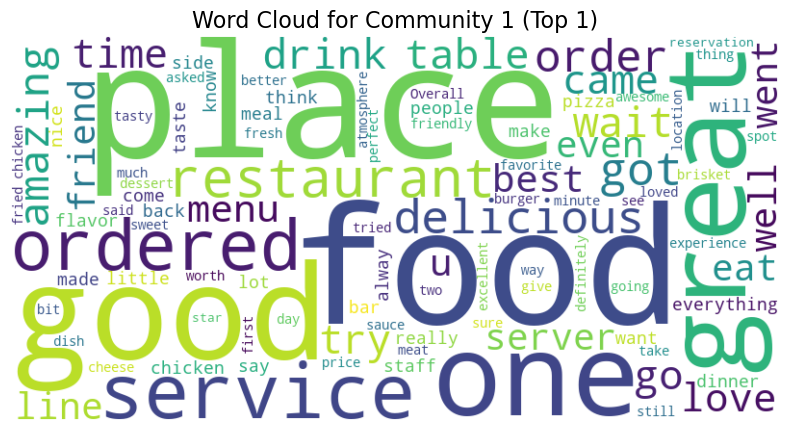

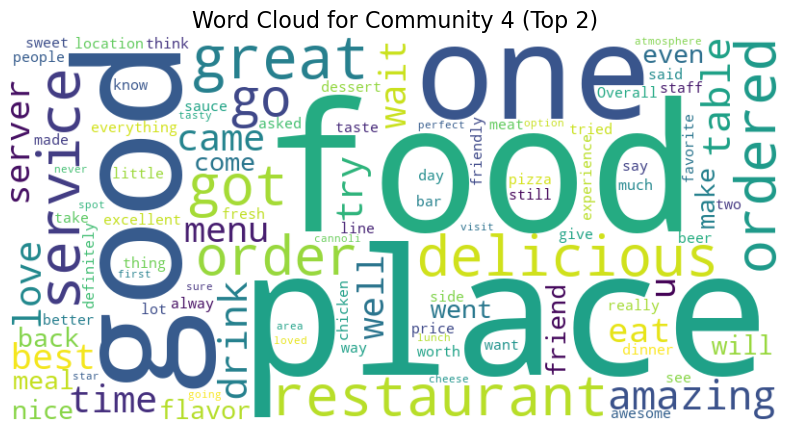

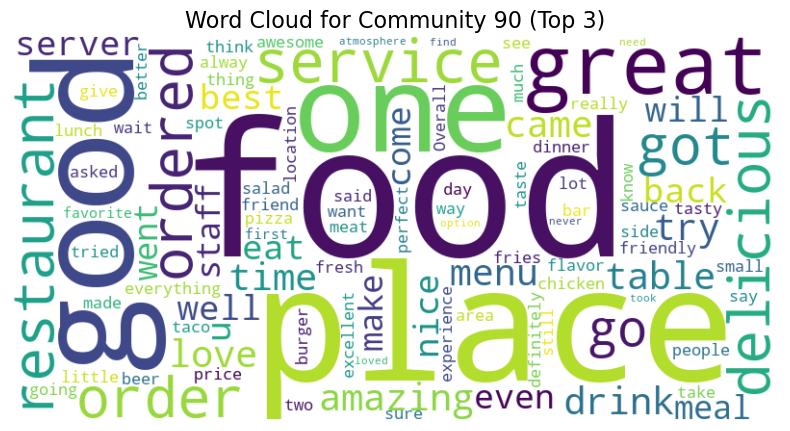

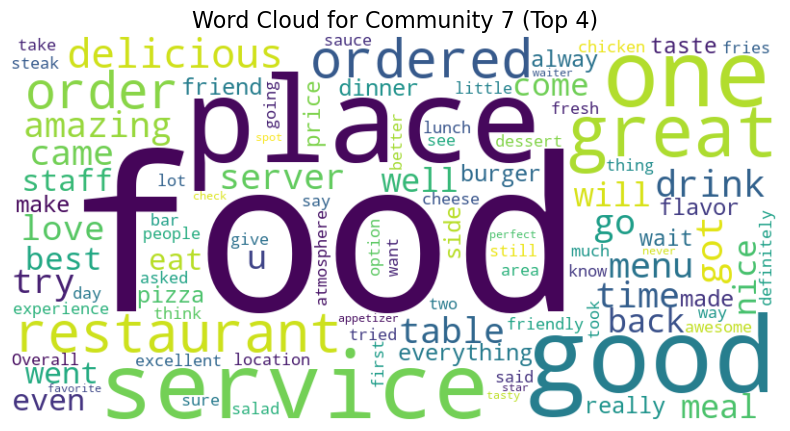

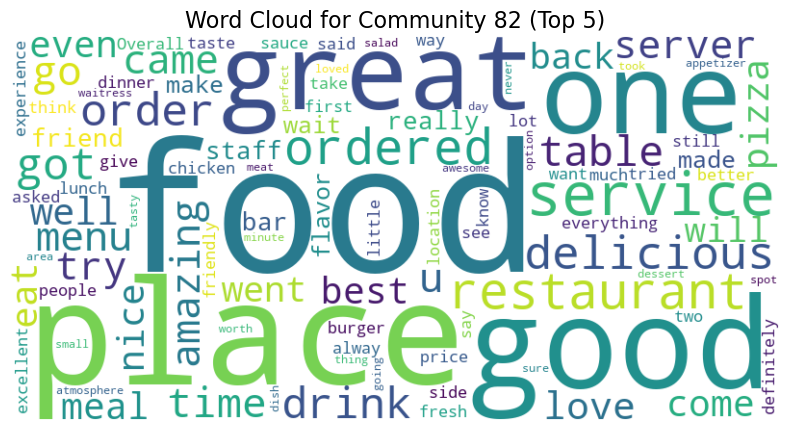

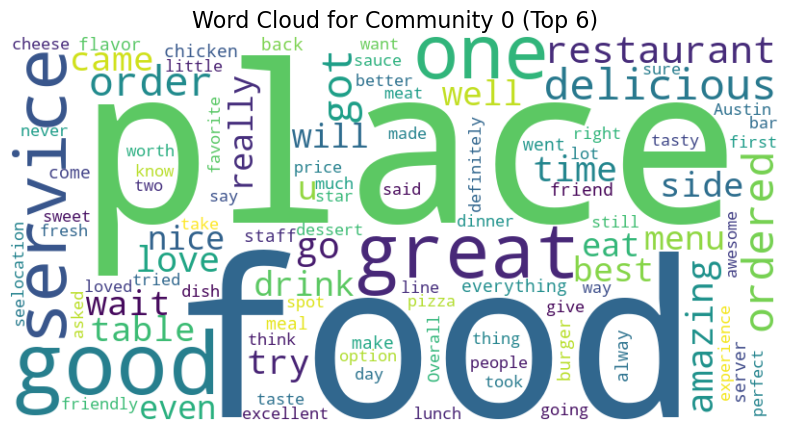

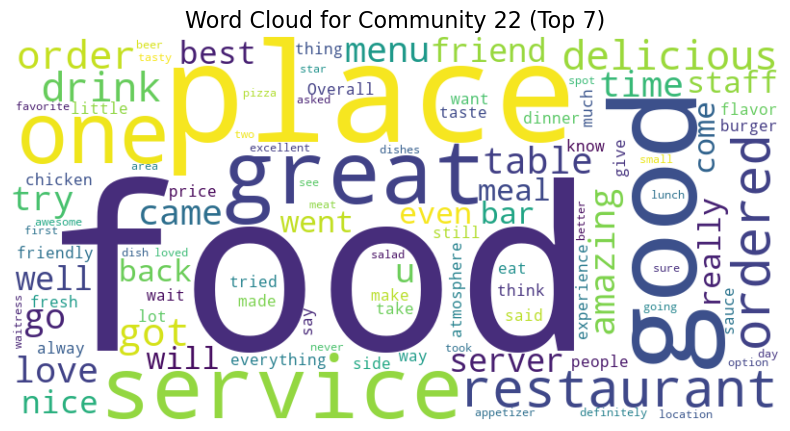

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Group reviews by business_id
grouped_reviews = data.groupby('business_id')['text_'].apply(lambda x: " ".join(x)).to_dict()

# Step 2: Aggregate reviews by community
community_reviews = defaultdict(str)

for node, community_id in louvain_partition.items():
    if node in grouped_reviews:  # Only add if the node has reviews
        community_reviews[community_id] += grouped_reviews[node]

# Step 3: Identify the Top 7 Communities with Non-Empty Reviews
top_communities = sorted(community_reviews.items(), key=lambda x: len(x[1]), reverse=True)[:7]

# Step 4: Generate Word Clouds for Each Top Community
for idx, (community_id, reviews) in enumerate(top_communities):
    # Skip empty communities
    if not reviews.strip():
        print(f"Community {community_id} has no reviews. Skipping.")
        continue

    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color='white',
        max_words=100
    ).generate(reviews)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Community {community_id} (Top {idx + 1})", fontsize=16)
    plt.show()


### Saving the network with the heighest weighted category and city as attributes to ease the further analysis process.  

In [45]:
# Load the graph (replace with your graph file or generation method)
with open('business_graph_threshold.pkl', 'rb') as f:
    G = pickle.load(f)

# Add 'categories' as a node attribute
nx.set_node_attributes(G, categories_mapping, 'categories')

# Add 'city' as a node attribute
nx.set_node_attributes(G, city_mapping, 'city')

# Calculate Louvain communities
louvain_partition = community_louvain.best_partition(G)

# Assign Louvain community IDs as node attributes
nx.set_node_attributes(G, louvain_partition, 'louvain_community')

# Assign each node the highest-weighted category based on existing category weights
for node in G.nodes:
    # Retrieve categories for the node
    all_categories = G.nodes[node].get('categories', ["No Category"])
    if isinstance(all_categories, str):
        # Convert string to list if needed
        all_categories = [cat.strip() for cat in all_categories.split(",")]

    # Assign the highest-weighted category
    if all_categories:
        highest_category = max(all_categories, key=lambda cat: category_weights.get(cat, 0))
    else:
        highest_category = "No Category"
    
    G.nodes[node]['categories'] = highest_category  # Replace with single category

# Retain only 'city' and 'categories' attributes
for node in G.nodes:
    node_data = G.nodes[node]
    filtered_attributes = {
        'city': node_data.get('city', 'Unknown City'),
        'categories': node_data.get('categories', 'No Category'),
        'louvain_community': node_data.get('louvain_community', 'Unknown')  # Optional
    }
    G.nodes[node].clear()
    G.nodes[node].update(filtered_attributes)

# Save the updated graph
with open('business_graph_with_filtered_attributes.pkl', 'wb') as f:
    pickle.dump(G, f)

print("Graph saved with filtered attributes.")


Graph saved with filtered attributes.


In [51]:
# Load the graph
with open('business_graph_with_filtered_attributes.pkl', 'rb') as f:
    G_filtered = pickle.load(f)

# Verify the graph
print(f"Loaded graph with {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")

# Inspect a few nodes
for node, data in list(G_filtered.nodes(data=True))[:10]:
    print(f"Node: {node}, Attributes: {data}")


Loaded graph with 8512 nodes and 32471 edges.
Node: rgGJMwcrNTuCcY493q_YuA, Attributes: {'city': 'Vancouver', 'categories': 'Nightlife', 'louvain_community': 0}
Node: YZs1gNSh_sN8JmN_nrpxeA, Attributes: {'city': 'Austin', 'categories': 'Sandwiches', 'louvain_community': 0}
Node: 5OAi35OianJzCnIsL8aOFQ, Attributes: {'city': 'Austin', 'categories': 'Mexican', 'louvain_community': 0}
Node: bZiIIUcpgxh8mpKMDhdqbA, Attributes: {'city': 'Austin', 'categories': 'American (Traditional)', 'louvain_community': 0}
Node: F6b_O4-wtd3956YOvAoerg, Attributes: {'city': 'Austin', 'categories': 'Nightlife', 'louvain_community': 0}
Node: _QUh5vFHSuw8R_uiFZ7XKQ, Attributes: {'city': 'Boston', 'categories': 'Nightlife', 'louvain_community': 0}
Node: KEh3efWSOIzd8BvuW-X4-g, Attributes: {'city': 'Austin', 'categories': 'American (Traditional)', 'louvain_community': 0}
Node: v1UzkU8lEWdjxq8byWFOKg, Attributes: {'city': 'Austin', 'categories': 'Chicken Wings', 'louvain_community': 0}
Node: 9UThLJTuOQPLcDCLx5BV